In [2]:
import numpy as np
import healpy as hp
import math
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from statistics import mean
from scipy.optimize import curve_fit
from astropy_healpix import HEALPix

Unimportant testing of masks vvv

MATH\
n=sqrt(len(array)/12)\
l=total length of chain= 2n+1 [(4,8,12,16,16,16,16,16,16,16,16,16,12,8,4); l=9]\
N=total number of rows=(4n-1) [above,n=4,#rows=15]\
S=total sum=12n^2\
lt=thickness of each row in degrees=180/N (above, N=15, lt=180/15=12)\
s=number of rows from lat=0= ROUND UP: s=desired region cut out/lt\
index=len(array)-(2n(n-1)+4n(n-s))\ <-- iff s<=n\
th=thickness=(2s+1)*(4n)

Real stuff vvv

In [55]:
def cscb_Temp_fit(file,Mhertz,deg,coords,ThermoTemp):
    #We first convert the array to a list to go faster
    if Mhertz==1420:#1420 MHz is the only one on this list (so far) that is in mK
        File_as_List=(hp.read_map(file)/1000).tolist()
    else:
        File_as_List=(hp.read_map(file)).tolist()
    #If we start in thermo-temp, we make sure to converto to antenna temp:
    if ThermoTemp==True:
        convert_to_TA(File_as_List,Mhertz)
    #Next, we define our theta coords to bin each value by csc|b|, making sure to go to galactic
    npix=int(np.sqrt(len(File_as_List)/12)) #12*NPix^2=total number of pixels
    theta1,phi1=hp.pix2ang(npix,np.arange(len(File_as_List)))
    if coords=="E":
        r = hp.rotator.Rotator(coord=['E','G'])
        theta=np.degrees(r(theta1,phi1)[0])
    if coords=="C":
        r = hp.rotator.Rotator(coord=['C','G'])
        theta=np.degrees(r(theta1,phi1)[0])
    if coords=="G":
        theta=np.degrees(theta1)
    cscb_Temp_values=[[],[],[],[],[],[],[],[],[],[]] #each entry represents an 0.5 increase from 1.25 (1.25,1.75,2.25...)
    #Now, we bin each real temp and its corresponding theta (b) by csc|b|
    for x in range(int(len(File_as_List))):
        if not File_as_List[x]<=0 and math.isnan(File_as_List[x])==False: #ignore hp.UNSEEN and 0 pixels
            range_csc=0
            desired_csc=1/np.sin(abs(np.radians(theta[x]-90)))
            while range_csc<=9 and abs(theta[x]-90)>10:
                if range_csc/2+1<desired_csc<range_csc/2+1.5: #append all values within 0.25 csc |b|
                    test=File_as_List[x]
                    cscb_Temp_values[range_csc].append(test)
                    range_csc=range_csc+10
                    break
                else:
                    range_csc=range_csc+1 #if the entry is not within 1<x<1.5, increase to 1.5<x<2.0 (for 1.75), etc.
    #Finally, we make our plots
    Mean_cscb_Temp=[]
    x_values=[]
    freq_values=0.75
    for i in range(10):
        freq_values=freq_values+0.5
        if not cscb_Temp_values[i]==[]:
            Mean_cscb_Temp.append(mean(cscb_Temp_values[i])) # we mean the temperature and create a scatter plot
            x_values.append(freq_values)
    plt.scatter(x_values,Mean_cscb_Temp)
    y_values = np.array(Mean_cscb_Temp)
    a, b = np.polyfit(x_values,y_values, 1) #fit the data
    plt.plot(x_values,a*np.array(x_values)+b)
    plt.title("csc|b| vs Temp at %s MHz" % Mhertz)
    plt.xlabel("csc|b|")
    plt.ylabel("Antenna Temp (K)")
    plt.grid()
    plt.show()
    T_gal=a
    c=b
    print(c)
    print(T_gal)
    c_array.append(c)
    freq.append(Mhertz)
    Temp.append(T_gal)


In [56]:
def convert_to_TA(array,freq):
    for x in range(len(array)):
        if not array[x]<=0 or array[x]==np.inf:
            IGL=(6.62607015*(10**(-34))*freq*10**6)/(1.380649*(10**(-23))*array[x])
            array[x]=(IGL/(np.exp(IGL)-1))*array[x]

/tmp/ipykernel_79/190720717.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  desired_csc=1/np.sin(abs(np.radians(theta[x]-90)))


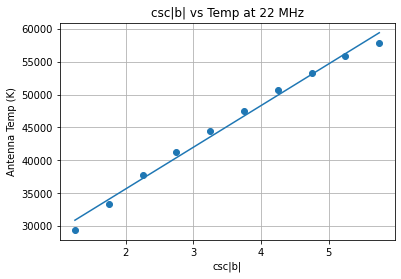

22990.067066401487
6332.033081658033


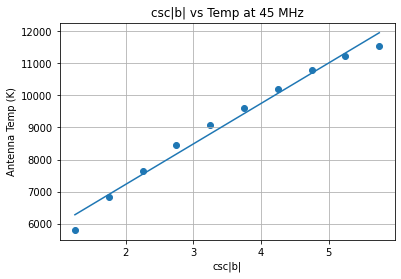

4708.353481281069
1259.5681597181856


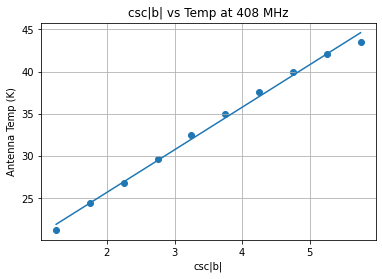

15.619456977382441
5.039877255823244


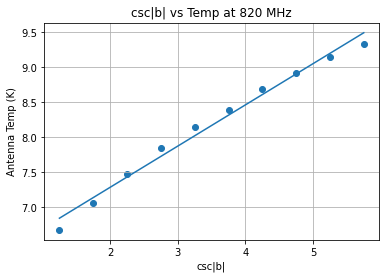

6.105559181652716
0.5895595087267913


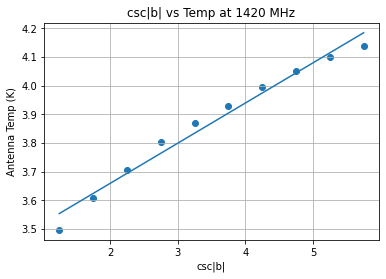

3.379112723272718
0.13999184301380127


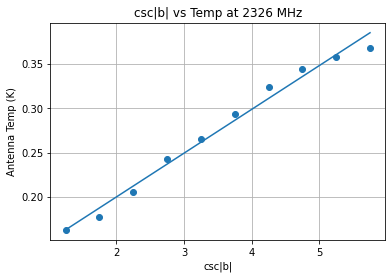

0.10150684065270674
0.04934867001927273


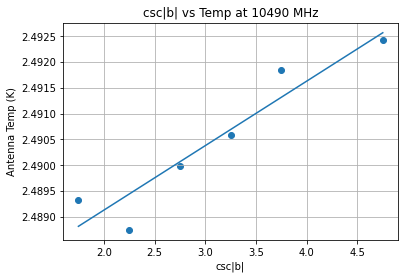

2.486624614689329
0.0012516781606378747


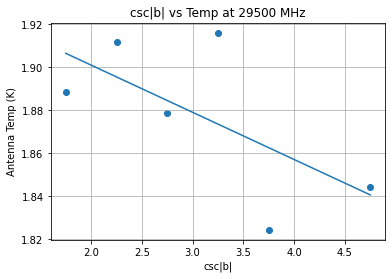

1.9449780105208063
-0.021963513971664305


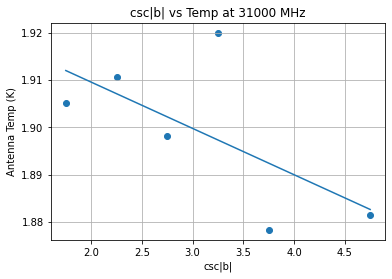

1.9291145382861348
-0.00978905427202983


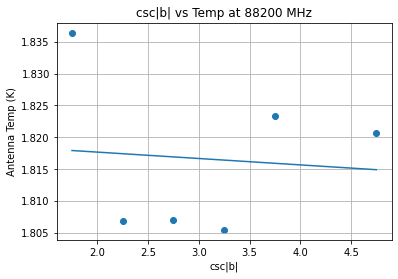

1.8196916039742361
-0.0010020346665983765


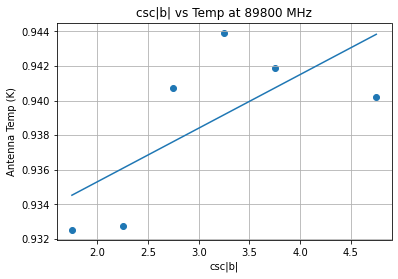

0.9290940863528745
0.003102844743991682


In [60]:
deg=85
c_array=[]
freq=[]
Temp=[]
#fornengo files
cscb_Temp_fit("lambda_DRAO_22MHz_1_256.fits",22,deg,"G",False)
cscb_Temp_fit("MAIPU_MU_1_64.fits",45,deg,"G",False)
cscb_Temp_fit("haslam408_dsds_Remazeilles2014.fits",408,deg,"G",False)
cscb_Temp_fit("Dwingeloo_Kelvins_1_256.fits",820,deg,"G",False)
cscb_Temp_fit("STOCKERT+VILLA-ELISA_1420MHz_1_256.fits",1420,deg,"G",False)
cscb_Temp_fit("lambda_23de_hea.fits",2326,deg,"C",False)
#LWA files
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-35.fits",35,deg,"C",False)
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-38.fits",38,deg,"C",False)
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-40.fits",40,deg,"C",False)
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-45.fits",45,deg,"C",False)
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-50.fits",50,deg,"C",False)
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-60.fits",60,deg,"C",False)
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-70.fits",70,deg,"C",False)
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-74.fits",74,deg,"C",False)
#cscb_Temp_fit("LWA Files/healpix-all-sky-rav-wsclean-map-80.fits",80,deg,"C",False)
#ARCADE files
#cscb_Temp_fit("ARCADE Files/arc2_3150_v19.fits",3150,deg,"G",True)
#cscb_Temp_fit("ARCADE Files/arc2_3410_v19.fits",3410,deg,"G",True)
#cscb_Temp_fit("ARCADE Files/arc2_7970_v19.fits",7970,deg,"G",True)
#cscb_Temp_fit("ARCADE Files/arc2_8330_v19.fits",8330,deg,"G",True)
#cscb_Temp_fit("ARCADE Files/arc2_9720_v19.fits",9720,deg,"G",True)
#cscb_Temp_fit("ARCADE Files/arc2_10490_v19.fits",10490,deg,"G",True)
#See pg 2 as to why we dont include vvv
#cscb_Temp_fit("ARCADE Files/arc2_29500_v19.fits",29500,deg,"G",True)
#cscb_Temp_fit("ARCADE Files/arc2_31000_v19.fits",31000,deg,"G",True)
#cscb_Temp_fit("ARCADE Files/arc2_88200_v19.fits",88200,deg,"G",True)
#cscb_Temp_fit("ARCADE Files/arc2_89800_v19.fits",89800,deg,"G",True)

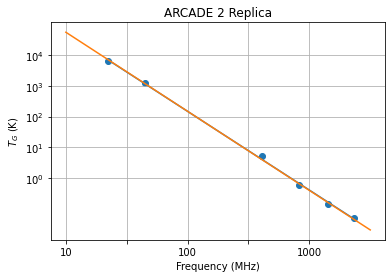

-2.565688369783429 7.299916112151929


In [58]:
plt.scatter(np.log10(freq),np.log10(Temp))
FreqFit = np.log10(freq)
TempFit = np.log10(np.array(Temp))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.plot(FreqFit,a*FreqFit+b)
plt.grid()
plt.yticks([0,1,2,3,4],["$10^0$","$10^1$","$10^2$","$10^3$","$10^4$"])
plt.xticks([1,1.5,2,2.5,3],["10","","100","","1000"])
plt.plot(np.array([1,2,3,3.5]),-2.5773016815785503*np.array([1,2,3,3.5])+7.324878050840692)
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("ARCADE 2 Replica")
plt.show()
print(a,b)